### 0. Imports and requirements

* Для моделирования нам понадобится реализация градиентного бустинга из `catboost` и `lightgbm`. Для обработки данных - стандартный DS стек из `pandas`, `numpy` и `sklearn`. Так как мы будем использовать по-настоящему огромные выборки (логи транзакций клиентов), то нужно будет эффективно читать данные и выделять из них признаки, чтобы иметь возможность строить решение даже на локальных машинах с большими ограничениями по RAM.  Поэтому нам понадобятся инструменты для работы с форматом данных `Parquet`. Библиотека `pandas` представляет необходимый инструментарий (рекомендуем установить модуль `fastparquet`, это позволит еще быстрее считывать данные).

In [1]:
%load_ext autoreload
%autoreload 2

import gc

import os
import sys
import pandas as pd
import numpy as np
import tqdm
import seaborn as sns


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score

import catboost as cb
import lightgbm as lgb

pd.set_option('display.max_columns', None)

# если у вас есть CUDA, то она понадобится там для экспериментов в catboost
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

sys.path.append('../')

### 1. Reading Data

* В данном соревновании участникам предстоит работать с таким форматом данных, как `Parquet`. Подробнее о нем почитать Вы можете самостоятельно. Самое главное - это крайне эффективный бинарный формат сжатия данных по колонокам. Однако для непосредственной работы с данными и построением моделей, нам нужно их прочитать и трансформировать в pandas.DataFrame. При этом сделать это эффективно по памяти.

In [2]:
TRAIN_TRANSACTIONS_PATH = '../../train_transactions_contest/'
TEST_TRANSACTIONS_PATH = '../../test_transactions_contest/'

TRAIN_TARGET_PATH = '../../train_target.csv'

In [3]:
from utils import read_parquet_dataset_from_local

* Для примера прочитаем одну партицию в память и оценим, сколько RAM она занимает

In [4]:
transactions_frame = read_parquet_dataset_from_local(TRAIN_TRANSACTIONS_PATH, start_from=0, num_parts_to_read=1)

memory_usage_of_frame = transactions_frame.memory_usage(index=True).sum() / 10**9
expected_memory_usage = memory_usage_of_frame * 50
print(f'Объем памяти в  RAM одной партиции данных с транзакциями: {round(memory_usage_of_frame, 3)} Gb')
print(f'Ожидаемый размер в RAM всего датасета: {round(expected_memory_usage, 3)} Gb')


Объем памяти в  RAM одной партиции данных с транзакциями: 0.476 Gb
Ожидаемый размер в RAM всего датасета: 23.798 Gb


* Итого, если у вас обычный локальный компьютер, то скорее всего весь датасет в памяти не уместится - вам потребуется значительный объем RAM или дополнительные ресурсы. Решение - читать данные итеративно. Партиции организованы таким образом, что  для конкретного клиента вся информация о его транзакциях до момента подачи заявки на кредит расположена внутри одной партиции (транзакции сгруппированы по полю `app_id`). Это позволяет загружать данные в память кусками, выделять все необходимые признаки и получать результирующий фрейм для моделирования. Для этих целей мы предоставляем вам функцию `utils.read_parquet_dataset_from_local`.

Так же все партиции с транзакциями упорядочены по возрастанию даты.

In [5]:
del transactions_frame
gc.collect()

40

### 2. Feature Extraction

* В рамках конкурса участникам предстоит работать с историей транзакций клиентов. На основе истории транзакций нужно оценить насколько благонадежным является клиент и определить, шансы того, что он уйдет в дефолт. В качестве признаков участники будут использовать характеристики клиентских транзакций: сумму транзакции, категорию транзакции, время и многие другие. Подробнее можно будет узнать на странице конкурса.


* Для бейзлайна мы подготовили функцию `features.extract_basic_aggregations`, она делает следующее:
     * на основе признака суммы транзакции `amnt` строит pivot_table для указанных категориальных признаков `cat_columns` и перечисленных функций агрегации. То есть, например, если в качестве агрегирующих функций указаны ['sum', 'mean', 'count'] и ['mcc_category'] в качестве `cat_columns`, то будут посчитаны общая сумма/среднее/количество транзакций по каждой конкретной категории признака `mcc_category`. Признаки расчитываются на основе фрейма транзакций для каждого клиента. 
     
     * Для численных признаков, таких как `amnt`, `hour_diff`, `days_before` расчитываются осмысленные статистики: минимум/максмимум/медиана/среднее...
     
     
 * Для обработки лога транзакций предлагается использовать функцию `prepare_transactions_dataset` ниже:

In [6]:
! rm -r ../../preprocessed_transactions/
! mkdir ../../preprocessed_transactions/

In [7]:
from features import extract_basic_aggregations

def prepare_transactions_dataset(path_to_dataset: str, num_parts_to_preprocess_at_once: int = 1, num_parts_total: int=50, 
                                 save_to_path=None, verbose: bool=False):
    """
    возвращает готовый pd.DataFrame с признаками, на которых можно учить модель для целевой задачи.
    path_to_dataset: str  
        путь до датасета с партициями
    num_parts_to_preprocess_at_once: int 
        количество партиций, которые будут одновременно держаться в памяти и обрабатываться
    num_parts_total: int 
        общее количество партиций, которые нужно обработать
    save_to_path: str
        путь до папки, в которой будет сохранен каждый обработанный блок в .parquet формате. Если None, то не будет сохранен 
    verbose: bool
        логирует каждый обрабатываемый кусок данных
    """
    preprocessed_frames = []
    block = 0
    for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once), 
                                   desc="Transforming transactions data"):
        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once, 
                                                             verbose=verbose)
        features = extract_basic_aggregations(transactions_frame, 
                                              cat_columns=['mcc_category', 'day_of_week', 'operation_type'])
        if save_to_path:
            block_as_str = str(block)
            if len(block_as_str) == 1:
                block_as_str = '00' + block_as_str
            else:
                block_as_str = '0' + block_as_str
            features.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))
            
        preprocessed_frames.append(features)
    return pd.concat(preprocessed_frames)

In [8]:
data = prepare_transactions_dataset(TRAIN_TRANSACTIONS_PATH, num_parts_to_preprocess_at_once=5, num_parts_total=50, 
                                    save_to_path='../../preprocessed_transactions/')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [9]:
print(f'Объем в RAM всего датасета: {round(data.memory_usage(index=True).sum() / 10**9, 3)} Gb')

Объем в RAM всего датасета: 0.979 Gb


* Обработаем тестовый набор данных и выделим все признаки:

In [10]:
! rm -r ../../preprocessed_test_transactions/
! mkdir ../../preprocessed_test_transactions/

In [11]:
test_data = prepare_transactions_dataset(TEST_TRANSACTIONS_PATH, num_parts_to_preprocess_at_once=5, num_parts_total=50, 
                                         save_to_path='../../preprocessed_test_transactions/')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [12]:
TEST_TARGET_PATH = '../../test_target_contest.csv'
test_target =  pd.read_csv(TEST_TARGET_PATH)
test_target.head()

,app_id,product
0,1063620,0
1,1063621,0
2,1063622,1
3,1063623,1
4,1063624,2


In [13]:
merged_test_data = test_data.merge(test_target[['app_id', 'product']], on='app_id')

* теперь можно переходить к моделированию и экспериментам. зафиксируем целевую метрику - `ROC AUC`. Результатом всех экспериментов будут серия следующих моделей:

| Name | Train | CV | Public Test|число признаков
| :-: | :-: | :-: | :-: | :-: |
| lgb+cv(5) | 0.801 | 0.77 |  0.737 | 127
|catboost+cv(5)| 0.775| 0.764 | 0.732 | 127
|lgb+cv(5)+split_importance(top 64 feats)| 0.795| 0.767 | 0.735| 64
| lgb+cv(5)+permutation_importance(top 57 feats) | 0.796 | 0.768 |  0.736 | 57
| lgb+cv(5)+target_permutation(top 60 feats) | 0.796 | 0.766 |  0.733 | 60

* Вы можете перейти сразу же к интересующему вас подходу и скорее приниять участие в конкурсе!

### 3. LightGBM + CV

* Начнем с градиентного бустинга из библиотеки `LightGBM`. Самое главное - всегда выделять валидационную выборку, чтобы контролировать обучение и не переобучаться. Можно выделять отложенную выборку по времени, случайную выборку,  использовать стратифицированное разбиение по целевой переменной или кросс-валидацию.

In [14]:
targets = pd.read_csv(TRAIN_TARGET_PATH)
targets.head()

,app_id,product,flag
0,0,3,0
1,1,1,0
2,2,1,0
3,3,1,0
4,4,1,0


* Добавим целевую переменную `flag`  и признак `product` к выделенным агрегациям по клиентам

In [15]:
merged_data = data.merge(targets[['app_id', 'product', 'flag']], on=['app_id'])

In [16]:
features = [x for x in merged_data.columns if x not in ['app_id', 'flag']]

In [17]:
targets = merged_data.flag.values

cv = KFold(n_splits=5, random_state=100, shuffle=True)

oof = np.zeros(len(merged_data))
train_preds = np.zeros(len(merged_data))

models = []

tree_params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'max_depth': 3,
    'reg_lambda': 1,
    'num_leaves': 64,
    'n_jobs': 5,
    'n_estimators': 1000
}

for fold_, (train_idx, val_idx) in enumerate(cv.split(merged_data, targets), 1):
    print(f'Training with fold {fold_} started.')
    lgb_model = lgb.LGBMClassifier(**tree_params)
    train, val = merged_data.iloc[train_idx], merged_data.iloc[val_idx]
    
    lgb_model.fit(train[features], train.flag.values, eval_set=[(val[features], val.flag.values)],
              early_stopping_rounds=50, verbose=50)

    
    oof[val_idx] = lgb_model.predict_proba(val[features])[:, 1]
    train_preds[train_idx] += lgb_model.predict_proba(train[features])[:, 1] / (cv.n_splits-1)
    models.append(lgb_model)
    print(f'Training with fold {fold_} completed.')

Training with fold 1 started.
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.733569
[100]	valid_0's auc: 0.745821
[150]	valid_0's auc: 0.751263
[200]	valid_0's auc: 0.755033
[250]	valid_0's auc: 0.757651
[300]	valid_0's auc: 0.759576
[350]	valid_0's auc: 0.760943
[400]	valid_0's auc: 0.762048
[450]	valid_0's auc: 0.763016
[500]	valid_0's auc: 0.763795
[550]	valid_0's auc: 0.764479
[600]	valid_0's auc: 0.765153
[650]	valid_0's auc: 0.765673
[700]	valid_0's auc: 0.766305
[750]	valid_0's auc: 0.766688
[800]	valid_0's auc: 0.767083
[850]	valid_0's auc: 0.767342
[900]	valid_0's auc: 0.7677
[950]	valid_0's auc: 0.768008
[1000]	valid_0's auc: 0.768269
Did not meet early stopping. Best iteration is:
[994]	valid_0's auc: 0.768277
Training with fold 1 completed.
Training with fold 2 started.
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.735806
[100]	valid_0's auc: 0.748626
[150]	valid_0's auc: 0.754227
[200]	valid_0's auc: 

In [18]:
'Train roc-auc', roc_auc_score(targets, train_preds)

('Train roc-auc', 0.8010773873216802)

In [19]:
'CV roc-auc', roc_auc_score(targets, oof)

('CV roc-auc', 0.7709463271925069)

* Подготовим посылку в проверяющую систему:

In [20]:
score = np.zeros(len(merged_test_data))

for model in tqdm.tqdm_notebook(models):
    score += model.predict_proba(merged_test_data[features])[:, 1] / len(models)
    
submission = pd.DataFrame({
    'app_id' : test_data.app_id.values,
    'score': score
}) 

submission.to_csv('sub.csv', index=None) # ~ 0.737 roc-auc на public test

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


### 4.  Виды Feature Importance

* Важный шаг в построении моделей - оценка важности признаков. `LightGBM` имеет внутренние способы оценки важности признаков - на основе того, как часто делается сплит в вершине по признаку (`split`) и на основе того, какой суммарный прирост в информации дает разбиение по признаку (`gain`). Используем первый способ оценки важности признаков. Затем отберем топ признаков по важности и построим на них новые модели.

In [21]:
importances = np.zeros(len(features))
for model in models:
    importances += model.feature_importances_ / len(models)

In [22]:
def plot_feature_importance(feature_names, feature_scores, top_feats=20, title='Importance', x_label='Importance', 
                            y_label='Features'):
    tuples = [(name, round(score, 3)) for name, score in zip(feature_names, feature_scores)]
    tuples = sorted(tuples, key=lambda x: x[1])[-top_feats:]
    
    labels, values = zip(*tuples)
    _, ax = plt.subplots(1, 1, figsize=(10, 8))
    ylocs = np.arange(len(values))
    
    ax.barh(ylocs, values, align='center', height=0.4)
    for x, y in zip(values, ylocs):
        ax.text(x + 1, y, x, va='center')
        
    ax.set_yticks(ylocs)
    ax.set_yticklabels(labels)
    xlim = (0, max(values) * 1.1)
    ax.set_xlim(xlim)
    ylim = (-1, len(values))
    ax.set_ylim(ylim)
    
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.grid(True)

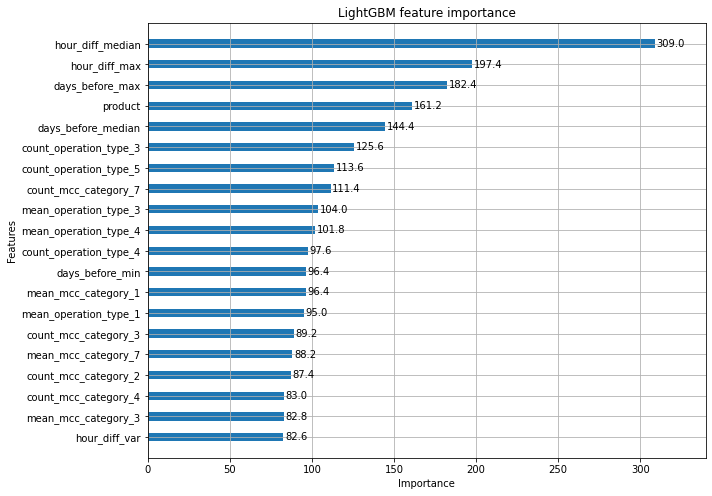

In [23]:
plot_feature_importance(features, importances, top_feats=20, title='LightGBM feature importance', 
                        x_label='Importance')

In [24]:
tuples = [(name, round(score, 3)) for name, score in zip(features, importances)]
tuples = sorted(tuples, key=lambda x: x[1])

top_selected_feats = [x[0] for x in tuples if x[1] >= np.median(importances)]

In [25]:
targets = merged_data.flag.values

cv = KFold(n_splits=5, random_state=100, shuffle=True)

oof = np.zeros(len(merged_data))
train_preds = np.zeros(len(merged_data))

new_models = []

tree_params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'max_depth': 3,
    'reg_lambda': 1,
    'num_leaves': 64,
    'n_jobs': 5,
    'n_estimators': 1000
}


for fold_, (train_idx, val_idx) in enumerate(cv.split(merged_data, targets), 1):
    print(f'Training with fold {fold_} started.')
    lgb_model = lgb.LGBMClassifier(**tree_params)
    train, val = merged_data.iloc[train_idx], merged_data.iloc[val_idx]
    
    lgb_model.fit(train[top_selected_feats], train.flag.values, eval_set=[(val[top_selected_feats], val.flag.values)],
              early_stopping_rounds=50, verbose=50)

    
    oof[val_idx] = lgb_model.predict_proba(val[top_selected_feats])[:, 1]
    train_preds[train_idx] += lgb_model.predict_proba(train[top_selected_feats])[:, 1] / (cv.n_splits-1)
    new_models.append(lgb_model)
    print(f'Training with fold {fold_} completed.')

Training with fold 1 started.
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.732084
[100]	valid_0's auc: 0.743481
[150]	valid_0's auc: 0.749082
[200]	valid_0's auc: 0.752432
[250]	valid_0's auc: 0.7548
[300]	valid_0's auc: 0.756623
[350]	valid_0's auc: 0.757892
[400]	valid_0's auc: 0.758939
[450]	valid_0's auc: 0.759745
[500]	valid_0's auc: 0.760493
[550]	valid_0's auc: 0.761238
[600]	valid_0's auc: 0.761822
[650]	valid_0's auc: 0.762326
[700]	valid_0's auc: 0.762875
[750]	valid_0's auc: 0.763263
[800]	valid_0's auc: 0.76367
[850]	valid_0's auc: 0.763982
[900]	valid_0's auc: 0.764452
[950]	valid_0's auc: 0.764759
[1000]	valid_0's auc: 0.765034
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.765038
Training with fold 1 completed.
Training with fold 2 started.
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.734728
[100]	valid_0's auc: 0.747884
[150]	valid_0's auc: 0.753116
[200]	valid_0's auc: 0

In [26]:
'Train roc-auc', roc_auc_score(targets, train_preds)

('Train roc-auc', 0.7964627929564552)

In [27]:
'CV roc-auc', roc_auc_score(targets, oof)

('CV roc-auc', 0.7683256742004549)

In [28]:
score = np.zeros(len(merged_test_data))

for model in tqdm.tqdm_notebook(new_models):
    score += model.predict_proba(merged_test_data[top_selected_feats])[:, 1] / len(models)
    
submission = pd.DataFrame({
    'app_id' : test_data.app_id.values,
    'score': score
}) # ~ 0.7346 на public test

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


* Другой эффективный и простой способ оценки важности признаков - `permutation importance`. Такой способ оценки важности признаков можно применить к любой обученной модели на табличных данных. Данный тип важности определеяется для каждого признака, как изменение в скоре (в нашем случае - `roc_auc`) при случайном перемешиваниии столбца  с значениями этого признака несколько раз. Можно использовть реализацию из `sklearn`.

In [29]:
permut_importance = np.zeros(len(features))

for fold_, (_, val_idx) in enumerate(cv.split(merged_data, targets), 1):
    print(f'Compute with fold {fold_} started.')
    val = merged_data.iloc[val_idx]
    importances_report = permutation_importance(models[fold_-1], val[features], val.flag.values, n_repeats=3, 
                                     n_jobs=3, scoring='roc_auc')
    permut_importance += importances_report.importances_mean / cv.n_splits
    print(f'Computation with fold {fold_} completed.')

Compute with fold 1 started.
Computation with fold 1 completed.
Compute with fold 2 started.
Computation with fold 2 completed.
Compute with fold 3 started.
Computation with fold 3 completed.
Compute with fold 4 started.
Computation with fold 4 completed.
Compute with fold 5 started.
Computation with fold 5 completed.


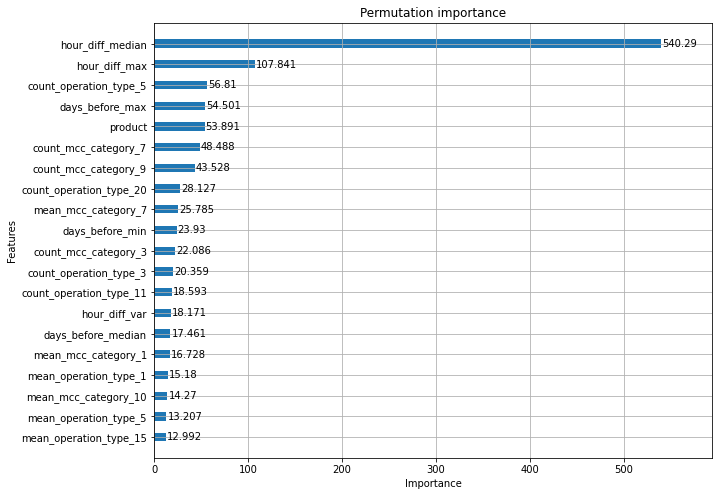

In [30]:
plot_feature_importance(features, permut_importance*10000, top_feats=20, title='Permutation importance', 
                        x_label='Importance')

* Используя техники оценки важности признаков можно интерпретировать модель, пытаться генерировать новые признаки или упрощать модель, удаляя самые неинформативные. Попробуем оставить топ информативных признаков (с точки зрения) `permutation importance`. Удаление из модели признаков, как правило, уменьшает ее склонность к переобучению. А самое главное - может существенно ускорить процесс обучения и последующий процесс использования ее в продуктовых целях.

In [31]:
tuples = [(name, round(score, 3)) for name, score in zip(features, permut_importance)]
tuples = sorted(tuples, key=lambda x: x[1])

top_selected_feats = [x[0] for x in tuples if x[1] > 0]

In [32]:
targets = merged_data.flag.values

cv = KFold(n_splits=5, random_state=100, shuffle=True)

oof = np.zeros(len(merged_data))
train_preds = np.zeros(len(merged_data))

new_models = []

tree_params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'max_depth': 3,
    'reg_lambda': 1,
    'num_leaves': 64,
    'n_jobs': 5,
    'n_estimators': 1000
}


for fold_, (train_idx, val_idx) in enumerate(cv.split(merged_data, targets), 1):
    print(f'Training with fold {fold_} started.')
    lgb_model = lgb.LGBMClassifier(**tree_params)
    train, val = merged_data.iloc[train_idx], merged_data.iloc[val_idx]
    
    lgb_model.fit(train[top_selected_feats], train.flag.values, eval_set=[(val[top_selected_feats], val.flag.values)],
              early_stopping_rounds=50, verbose=50)

    
    oof[val_idx] = lgb_model.predict_proba(val[top_selected_feats])[:, 1]
    train_preds[train_idx] += lgb_model.predict_proba(train[top_selected_feats])[:, 1] / (cv.n_splits-1)
    new_models.append(lgb_model)
    print(f'Training with fold {fold_} completed.')

Training with fold 1 started.
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.732619
[100]	valid_0's auc: 0.74496
[150]	valid_0's auc: 0.750623
[200]	valid_0's auc: 0.754076
[250]	valid_0's auc: 0.756627
[300]	valid_0's auc: 0.758594
[350]	valid_0's auc: 0.760053
[400]	valid_0's auc: 0.761259
[450]	valid_0's auc: 0.762265
[500]	valid_0's auc: 0.76314
[550]	valid_0's auc: 0.763808
[600]	valid_0's auc: 0.764413
[650]	valid_0's auc: 0.764822
[700]	valid_0's auc: 0.765343
[750]	valid_0's auc: 0.76579
[800]	valid_0's auc: 0.766203
[850]	valid_0's auc: 0.766536
[900]	valid_0's auc: 0.76681
[950]	valid_0's auc: 0.766891
[1000]	valid_0's auc: 0.767051
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.767063
Training with fold 1 completed.
Training with fold 2 started.
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.734876
[100]	valid_0's auc: 0.747566
[150]	valid_0's auc: 0.753169
[200]	valid_0's auc: 0.

In [33]:
'Train roc-auc', roc_auc_score(targets, train_preds)

('Train roc-auc', 0.7970652111991933)

In [34]:
'CV roc-auc', roc_auc_score(targets, oof)

('CV roc-auc', 0.7697037325078495)

In [35]:
score = np.zeros(len(merged_test_data))

for model in tqdm.tqdm_notebook(new_models):
    score += model.predict_proba(merged_test_data[top_selected_feats])[:, 1] / len(models)
    
submission = pd.DataFrame({
    'app_id' : test_data.app_id.values,
    'score': score
}) # ~ 0.736 roc-auc на public test

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


* Можно попробовать продвинутые способы изучения предсказаний модели - `SHAP values`. Мы используем так называемый `summary plot`, позволяющий получить общую картину о влиянии того или иного признака на предсказание модели визуализуруя всю выборку сразу.

In [36]:
train, val = train_test_split(merged_data, random_state=42, test_size=0.1)

tree_params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'max_depth': 3,
    'reg_lambda': 1,
    'num_leaves': 64,
    'seed': 100,
    'n_jobs': 5,
    'n_estimators': 1000
}

lgb_model = lgb.LGBMClassifier(**tree_params)
lgb_model.fit(train[features], train.flag.values, eval_set=[(val[features], val.flag.values)],
              early_stopping_rounds=50, verbose=-1)

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's auc: 0.776508


LGBMClassifier(learning_rate=0.05, max_depth=3, metric='auc', n_estimators=1000,
               n_jobs=5, num_leaves=64, objective='binary', reg_lambda=1,
               seed=100)

In [37]:
import shap

In [38]:
explainer = shap.TreeExplainer(lgb_model)

In [39]:
shap_values = explainer.shap_values(val[features])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


* результаты довольно хорошо согласуются с перестановочной важностью.

* что показывает этот график:
    * по вертикали отложена каждая фича
    * каждая точка графика - признак некоторого сэмпла
    * цвет - значение фичи, чем краснее - тем значение фичи выше, и наоборот
    * горизонтальное положение точки показывает, приводит ли значение конкретной фичи этого сэмпла к росту предсказания, или наоборот. Например, из графика можно увидеть тренд, что уменьшение признака `hour_diff_median` приводит к росту значения целевой переменной.

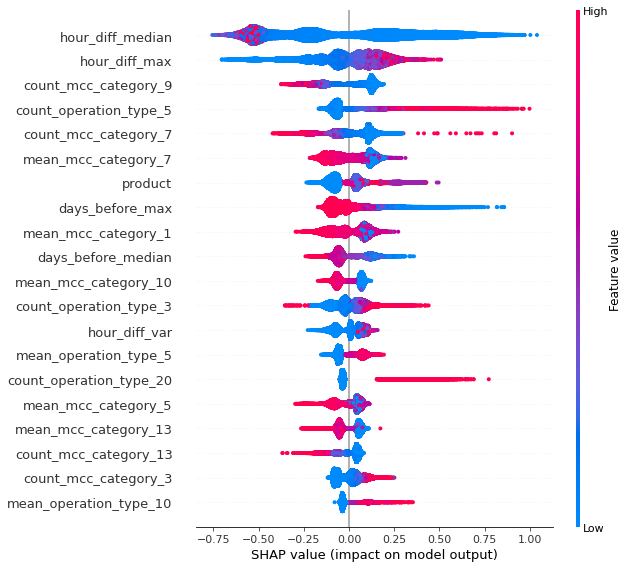

In [40]:
shap.summary_plot(shap_values[1], val[features])

* Еще одна интересная техника оценки важности и отбора признаков - `target permutation`


* Отбор признаков через `target permutation` основан на сравнении важности признака, которая быал получена при обучении на обычной выборке, с распределением важности этого признака для моделей, которые обучены на выборках с перемешанной целевой переменной.

In [41]:
def get_feature_importances(frame, shuffle=False, seed=100, importance_type='gain'):
    # запишем целевую target в переменную
    y = frame.flag.values.copy()
    if shuffle:
        # перемешаем целевую переменную
        y = frame.flag.copy().sample(frac=1.0).values
    
    # обучим случайный лес из LightGBM ( реализация гораздо быстрее, чем в sklearn )
    # сделаем это для того, чтобы не выделять отдельную выборку под валидацию для градиентного бустинга
    tree_params = {
    'objective': 'binary',
    'boosting_type': 'rf',
    'metric': 'auc',
    'subsample_freq': np.random.choice([5, 10, 15, 20]),
    'subsample': np.random.choice([0.6, 0.8, 0.9]),
    'max_depth': np.random.choice([7, 8, 10]),
    'num_leaves': 64,
    'seed': seed,
    'n_jobs': 5,
    'n_estimators': 100,
    'importance_type': importance_type
    }
    
    lgb_model = lgb.LGBMClassifier(**tree_params)
    lgb_model.fit(frame[features], y)
    
    importance = pd.DataFrame({
        'feature': features,
        f'importance_{importance_type}': lgb_model.feature_importances_,
        'score': roc_auc_score(y, lgb_model.predict_proba(frame[features])[:, 1])
    })
    
    return importance

* Посчитаем важность признаков (на основе количества сплитов по признаку в алгоритме random forest) при обучении на исходной выборке

In [42]:
real_importance = get_feature_importances(train, shuffle=False, seed=100, importance_type='split')
real_importance.head()

,feature,importance_split,score
0,count_mcc_category_1,60,0.712091
1,count_mcc_category_2,0,0.712091
2,count_mcc_category_3,0,0.712091
3,count_mcc_category_4,30,0.712091
4,count_mcc_category_5,0,0.712091


* Посчитаем важность признаков для выборок, у которых целевая переменная перемешана. То есть фактически, обучаем алгоритм на шуме.

In [43]:
def calculate_null_importance(frame, num_runs=80, importance_type='gain'):
    null_importance = pd.DataFrame()
    for i in tqdm.tqdm_notebook(range(num_runs)):
        # посчитаем текущую важность признаков при перемешивании целевой переменной
        importance = get_feature_importances(frame, shuffle=True, seed=None, importance_type=importance_type)
        importance['run'] = i + 1 
        null_importance = pd.concat([null_importance, importance], axis=0)
    return null_importance

In [44]:
null_importance = calculate_null_importance(train, num_runs=30, importance_type='split')

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


* Теперь имеем возможность для каждого признака построить гистограмму важности этого признака при обучении на выборке с перемешанным таргетом и на выборке с реальной целевой переменной. В идеале, гистограмма должна быть как можно дальше от реального значения важности признака

In [45]:
def plot_distribution(real_importance, null_importance, feature_name, importance_name='gain'):
    fig, ax = plt.subplots(figsize=(8, 6))
    a = ax.hist(null_importance.loc[null_importance['feature'] == feature_name, f'importance_{importance_name}'].values, 
                label='Null importances')
    
    ax.vlines(x=real_importance.loc[real_importance['feature'] == feature_name, f'importance_{importance_name}'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title(f'Split Importance of {feature_name}', fontweight='bold')
    plt.xlabel(f'Null Importance ({importance_name}) Distribution for {feature_name}')

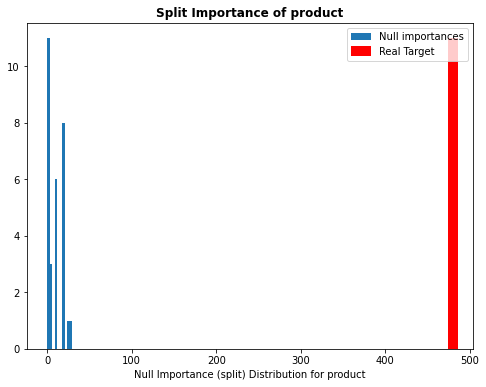

In [46]:
plot_distribution(real_importance, null_importance, feature_name='product', importance_name='split')

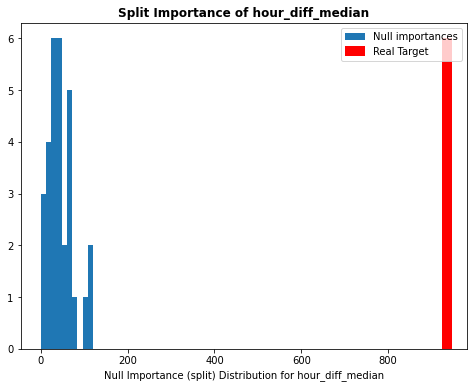

In [47]:
plot_distribution(real_importance, null_importance, feature_name='hour_diff_median', importance_name='split')

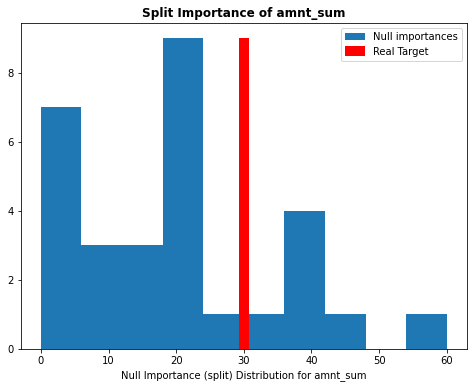

In [48]:
plot_distribution(real_importance, null_importance, feature_name='amnt_sum', importance_name='split')

* Попробуем поставить каждому признаку новый скор, важность, с учетом той информации, которую имеем. Один из вариантов - поделить раельноа значение важности признака на среднее значение для перемешанных важностей этого признака. 

In [49]:
scores = []
importance_name = 'split'

for feature in features:
    hist_null_importance = null_importance.loc[null_importance['feature'] == feature, f'importance_{importance_name}'].values
    actual_importance = real_importance.loc[real_importance['feature'] == feature, f'importance_{importance_name}'].mean()
    score = (1e-10 + actual_importance) / (1 + np.mean(hist_null_importance))        
    scores.append(round(score, 3))

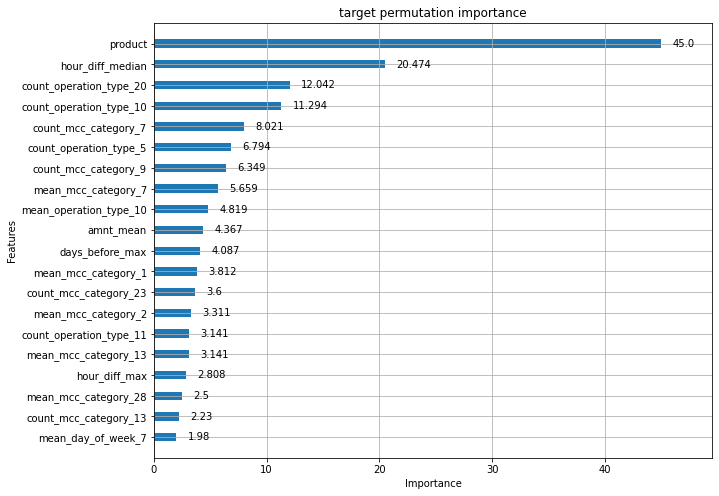

In [50]:
plot_feature_importance(features, scores, top_feats=20, title='target permutation importance', 
                        x_label='Importance')

In [51]:
tuples = [(name, round(score, 3)) for name, score in zip(features, scores)]
tuples = sorted(tuples, key=lambda x: x[1])

top_selected_feats = [x[0] for x in tuples if x[1] > 0]

In [52]:
targets = merged_data.flag.values

cv = KFold(n_splits=5, random_state=100, shuffle=True)

oof = np.zeros(len(merged_data))
train_preds = np.zeros(len(merged_data))

new_models = []

tree_params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'max_depth': 3,
    'reg_lambda': 1,
    'num_leaves': 64,
    'n_jobs': 5,
    'n_estimators': 1000
}


for fold_, (train_idx, val_idx) in enumerate(cv.split(merged_data, targets), 1):
    print(f'Training with fold {fold_} started.')
    lgb_model = lgb.LGBMClassifier(**tree_params)
    train, val = merged_data.iloc[train_idx], merged_data.iloc[val_idx]
    
    lgb_model.fit(train[top_selected_feats], train.flag.values, eval_set=[(val[top_selected_feats], val.flag.values)],
              early_stopping_rounds=50, verbose=50)

    
    oof[val_idx] = lgb_model.predict_proba(val[top_selected_feats])[:, 1]
    train_preds[train_idx] += lgb_model.predict_proba(train[top_selected_feats])[:, 1] / (cv.n_splits-1)
    new_models.append(lgb_model)
    print(f'Training with fold {fold_} completed.')

Training with fold 1 started.
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.73225
[100]	valid_0's auc: 0.743442
[150]	valid_0's auc: 0.748249
[200]	valid_0's auc: 0.751263
[250]	valid_0's auc: 0.753172
[300]	valid_0's auc: 0.754708
[350]	valid_0's auc: 0.755917
[400]	valid_0's auc: 0.756828
[450]	valid_0's auc: 0.757536
[500]	valid_0's auc: 0.758157
[550]	valid_0's auc: 0.758789
[600]	valid_0's auc: 0.759167
[650]	valid_0's auc: 0.759599
[700]	valid_0's auc: 0.760037
[750]	valid_0's auc: 0.760421
[800]	valid_0's auc: 0.760636
[850]	valid_0's auc: 0.760988
[900]	valid_0's auc: 0.761195
[950]	valid_0's auc: 0.761444
[1000]	valid_0's auc: 0.761556
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.761556
Training with fold 1 completed.
Training with fold 2 started.
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.735097
[100]	valid_0's auc: 0.747301
[150]	valid_0's auc: 0.752221
[200]	valid_0's auc

In [53]:
'Train roc-auc', roc_auc_score(targets, train_preds)

('Train roc-auc', 0.7930416296206335)

In [54]:
'CV roc-auc', roc_auc_score(targets, oof)

('CV roc-auc', 0.7650146788376628)

In [55]:
score = np.zeros(len(merged_test_data))

for model in tqdm.tqdm_notebook(new_models):
    score += model.predict_proba(merged_test_data[top_selected_feats])[:, 1] / len(models)
    
submission = pd.DataFrame({
    'app_id' : test_data.app_id.values,
    'score': score
}) # ~ 0.733 на public test

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


* После того, как бейзлайн построен - можно приступить к его улучшению. Во-первых, сгенерировать большое количество разнообразных фич на основе предложенных данных. Во-вторых, попробовать модели другой природы. 


* С увеличением количества признаков `LightGBM`  при запуске на CPU может начать работать очень медленно. Его можно ускорить, если скомпилировать под GPU, совместимую с CUDA. Альтернативно, при наличии совместимой с CUDA GPU, можно использовать `Catboost`, который поддерживает работу с видеокартой из коробки. Обучение на GPU на больших выборках дает ускорение обучения в разы. Так же, градиентный бустинг от Яндекса имеет огромное количество реализованных фичей: мониторинг обучения с графиками, поддержку интерпретируемости моделей и отбор признаков.

### 5. Catboost + GPU

In [56]:
targets = merged_data.flag.values

cv = KFold(n_splits=5, random_state=100, shuffle=True)

oof = np.zeros(len(merged_data))
train_preds = np.zeros(len(merged_data))

models = []


tree_params = {
    'max_depth': 5,
    'eval_metric': 'AUC',
    'loss_function': 'Logloss',
    'random_state': 100,
    'l2_leaf_reg': 1,
    'task_type': 'GPU' # если имеется GPU с CUDA, то можно ее задействовать, чтобы на порядок ускорить обучение
}


for fold_, (train_idx, val_idx) in enumerate(cv.split(merged_data, targets), 1):
    print(f'Training with fold {fold_} started.')
    model = cb.CatBoostClassifier(**tree_params)    
    
    train, val = merged_data.iloc[train_idx], merged_data.iloc[val_idx]
    
    train_pool = cb.Pool(train[features], train.flag.values)
    val_pool = cb.Pool(val[features], val.flag.values)
    

    model.fit(train_pool, eval_set=[val_pool], early_stopping_rounds=100, verbose_eval=50, use_best_model=True, plot=False)
    
    oof[val_idx] = model.predict_proba(val_pool)[:, 1]
    
    train_preds[train_idx] += model.predict_proba(train_pool)[:, 1] / (cv.n_splits-1)
    models.append(model)
    print(f'Training with fold {fold_} completed.')

Training with fold 1 started.
0:	learn: 0.6291874	test: 0.6279340	best: 0.6279340 (0)	total: 12.1ms	remaining: 12.1s
50:	learn: 0.7392549	test: 0.7347890	best: 0.7347890 (50)	total: 564ms	remaining: 10.5s
100:	learn: 0.7459507	test: 0.7409845	best: 0.7409845 (100)	total: 1.1s	remaining: 9.84s
150:	learn: 0.7513656	test: 0.7451563	best: 0.7451671 (148)	total: 1.64s	remaining: 9.25s
200:	learn: 0.7551616	test: 0.7483237	best: 0.7483237 (200)	total: 2.18s	remaining: 8.66s
250:	learn: 0.7582723	test: 0.7507600	best: 0.7507600 (250)	total: 2.7s	remaining: 8.06s
300:	learn: 0.7606609	test: 0.7526088	best: 0.7526088 (300)	total: 3.22s	remaining: 7.48s
350:	learn: 0.7623812	test: 0.7538738	best: 0.7538738 (350)	total: 3.75s	remaining: 6.93s
400:	learn: 0.7640367	test: 0.7551115	best: 0.7551115 (400)	total: 4.26s	remaining: 6.37s
450:	learn: 0.7655527	test: 0.7561742	best: 0.7561742 (450)	total: 4.78s	remaining: 5.82s
500:	learn: 0.7667744	test: 0.7570030	best: 0.7570030 (500)	total: 5.29s	rema

150:	learn: 0.7508613	test: 0.7512218	best: 0.7512218 (150)	total: 1.64s	remaining: 9.2s
200:	learn: 0.7543858	test: 0.7542209	best: 0.7542209 (200)	total: 2.17s	remaining: 8.62s
250:	learn: 0.7571681	test: 0.7565681	best: 0.7565681 (250)	total: 2.69s	remaining: 8.03s
300:	learn: 0.7594340	test: 0.7583472	best: 0.7583472 (300)	total: 3.21s	remaining: 7.47s
350:	learn: 0.7615779	test: 0.7598486	best: 0.7598486 (350)	total: 3.74s	remaining: 6.91s
400:	learn: 0.7630758	test: 0.7609280	best: 0.7609280 (400)	total: 4.26s	remaining: 6.36s
450:	learn: 0.7645462	test: 0.7618867	best: 0.7618867 (450)	total: 4.78s	remaining: 5.82s
500:	learn: 0.7657660	test: 0.7626562	best: 0.7626562 (500)	total: 5.3s	remaining: 5.28s
550:	learn: 0.7669195	test: 0.7632489	best: 0.7632489 (550)	total: 5.83s	remaining: 4.75s
600:	learn: 0.7679652	test: 0.7637425	best: 0.7637425 (600)	total: 6.34s	remaining: 4.21s
650:	learn: 0.7688950	test: 0.7642316	best: 0.7642316 (650)	total: 6.87s	remaining: 3.68s
700:	learn: 

In [57]:
'Train roc-auc', roc_auc_score(targets, train_preds)

('Train roc-auc', 0.7758456533245421)

In [58]:
'CV roc-auc', roc_auc_score(targets, oof)

('CV roc-auc', 0.7642830122285327)

In [59]:
score = np.zeros(len(merged_test_data))

test_pool = cb.Pool(merged_test_data[features])

for model in tqdm.tqdm_notebook(models):
    score += model.predict_proba(test_pool)[:, 1] / len(models)
    
submission = pd.DataFrame({
    'app_id' : test_data.app_id.values,
    'score': score
}) # ~ 0.732 на public test

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
